# Phase 2 - Data preprocessing
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## Loading the data

In [188]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
devices_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/devices.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

## Merging datasets

From the previous phase, after analysing each dataset, we came to the conclusion that the dataset with profiles would not be included in the federated dataset because it had many problems, such as a large number of missing values, different data formats, duplicate values for attributes such as `user_id` and `imei`, which simply complicated the merging. Also, this dataset did not have any important attributes that could also be encoded into a numeric format to help us predict the value of the `mwra` attribute.

Also, in the previous phase, we noticed that the 2 datasets, processes and connections, can be connected because they are logically related and have several attributes in common that are common to both of them:

In [189]:
connections_data['ts'].equals(processes_data['ts']) and connections_data['mwra'].equals(processes_data['mwra']) and connections_data['imei'].equals(processes_data['imei'])

True

In [190]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()

As for the device dataset, it has several attributes that
location-related attributes that can be coded, so we could try to connect these datasets.

### Merging the device dataset
Let's also check if we can connect a device dataset, but as we remember from phase 1, there are a lot of duplicate imeis in this dataset, which can make it difficult to join, because if there is an imei in the process/connection table that is not in the device table, we can get null values and simply lose this information when we clean it up, so it's worth checking this before doing it:

In [191]:
devices_imei_unique = devices_data.drop_duplicates(subset=['imei'], keep='first')
devices_imei_unique.shape[0]

500

In [192]:
result = pd.merge(devices_imei_unique, processes_data, on='imei', how='right')
result.shape[0]

15145

In [193]:
result.dropna()
result.shape[0]

15145

As we can see, after merging, we have not lost any information, i.e. for each row in the connections there is a corresponding device, so we can safely merge the device dataset into the shared data:

In [194]:
merged_data = pd.merge(devices_imei_unique, merged_data, on='imei', how='right')
merged_data.shape[0]

14965

Another feature of the device dataset is the `location` attribute, which can be divided into `continent` and `city` columns:

In [195]:
merged_data[['continent', 'city']] = merged_data['location'].str.split('/', expand=True, n=1).apply(lambda x: x.tolist() if len(x.dropna()) > 1 else [x[0], None], axis=1, result_type='expand')
merged_data = merged_data.drop(['location'], axis=1)

## Splitting up the data

"To avoid data leakage, data preparation must be fit on the training dataset only. Once fit, the data preparation pipeline can then be applied to the test dataset."
<p align="right">Giang Nguyen, "Introduction to Data Science"</p>

In [196]:
train_data, test_data = train_test_split(merged_data, test_size=0.25)

print('Training sample contains: '+ str(len(train_data))+' records')
print('Test sample contains: '+ str(len(test_data))+' records')

Training sample contains: 11223 records
Test sample contains: 3742 records


## Encoding non-numeric attributes


In this section, we will code the non-numeric attributes so that we can use them for analysis.

Let's see which attributes we need to code:

In [197]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11223 entries, 6013 to 1479
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    11223 non-null  float64
 1   longitude                   11223 non-null  float64
 2   store_name                  11223 non-null  object 
 3   code                        11196 non-null  object 
 4   imei                        11223 non-null  int64  
 5   ts                          11223 non-null  object 
 6   mwra                        11223 non-null  float64
 7   p.android.packageinstaller  11223 non-null  float64
 8   p.system                    11223 non-null  float64
 9   p.android.externalstorage   11223 non-null  float64
 10  p.android.documentsui       11223 non-null  float64
 11  p.android.gm                11223 non-null  float64
 12  p.android.settings          11223 non-null  float64
 13  p.android.chrome            11223 

As we can see, most attributes are already in numeric format, and only a few are not, namely:

- store_name
- code
- imei
- ts
- continent
- city

However, attributes such as:

- store_name
- code
- city

have a large variation, which will be difficult to map, and will not matter much.

The `imei` attribute is just a device ID, so it's also no longer relevant to us.

So we will simply remove these attributes.

In [198]:
train_data = train_data.drop(['store_name', 'code', 'city','imei'], axis=1)

We will still convert the `continent` and `ts` attributes to numeric values.

### Continent encoding

In [199]:
continent_mapping = {
    'Asia': 1,
    'America': 2,
    'Europe': 3,
    'Africa': 4,
    'Australia': 5,
    'Indian': 6,
    'Pacific': 7
}

train_data['continent'] = train_data['continent'].map(continent_mapping)

In [200]:
train_data['continent'].value_counts()

continent
1    3488
2    3123
3    3031
4    1335
5     122
6      84
7      40
Name: count, dtype: int64

As you can see, we now have new numerical values.

### Time stamp encoding

In [201]:
train_data['ts'] = pd.to_datetime(train_data['ts'], format='%Y-%m-%d %H:%M:%S')

train_data['year'] = train_data['ts'].dt.year
train_data['month'] = train_data['ts'].dt.month
train_data['day'] = train_data['ts'].dt.day
train_data['hour'] = train_data['ts'].dt.hour
train_data['minute'] = train_data['ts'].dt.minute
train_data['second'] = train_data['ts'].dt.second

train_data = train_data.drop(['ts'], axis=1)
train_data.head()

,latitude,longitude,mwra,p.android.packageinstaller,p.system,p.android.externalstorage,p.android.documentsui,p.android.gm,p.android.settings,p.android.chrome,...,c.UCMobile.x86,c.android.vending,c.raider,continent,year,month,day,hour,minute,second
6013,38.13708,41.00817,1.0,14.82308,9.32896,8.50529,6.14712,8.43480,7.79769,6.93888,...,42.02668,7.74125,22.64667,3,2018,5,9,14,13,0
14671,34.06635,-84.67837,1.0,8.03428,9.61130,8.85062,8.80981,11.45647,7.91003,9.91180,...,40.01546,36.82989,51.75234,2,2018,5,15,14,31,0
1775,13.81960,100.04427,1.0,10.34171,9.26788,11.17736,12.35639,15.41183,8.62512,10.91137,...,35.49776,49.52660,25.04038,1,2018,5,6,15,35,0
10690,38.58894,-89.99038,1.0,8.73798,10.14996,10.40773,13.01177,9.18792,10.33638,12.73541,...,67.49883,69.10909,1.18176,2,2018,5,12,20,10,0
8011,52.45810,13.28702,0.0,10.23225,8.91932,14.36024,13.85718,8.68346,13.17011,10.29314,...,47.30718,22.93541,74.66153,3,2018,5,10,23,31,0


In [202]:
train_data[['year', 'month','second']].value_counts()

year  month  second
2018  5      0         11223
Name: count, dtype: int64

As we can see, `year, month, second` have fixed values, so we will delete them as well.

In [203]:
train_data = train_data.drop(['year', 'month','second'], axis=1)

## Missing values

As we mentioned in the previous phase, the process and connection datasets did not have any missing values at all, and the device dataset had only 1 missing value, which was not included in the merged dataset anyway, since this value was in the `code` attribute, which we had already removed.

In [204]:
train_data.isnull().sum()

latitude                      0
longitude                     0
mwra                          0
p.android.packageinstaller    0
p.system                      0
p.android.externalstorage     0
p.android.documentsui         0
p.android.gm                  0
p.android.settings            0
p.android.chrome              0
p.olauncher                   0
p.inputmethod.latin           0
p.android.gms                 0
p.android.defcontainer        0
p.android.vending             0
p.dogalize                    0
p.simulator                   0
p.google                      0
p.process.gapps               0
p.katana                      0
p.gms.persistent              0
p.notifier                    0
p.browser.provider            0
c.katana                      0
c.dogalize                    0
c.android.gm                  0
c.android.chrome              0
c.android.youtube             0
c.UCMobile.intl               0
c.updateassist                0
c.UCMobile.x86                0
c.androi

## Outliers

In [205]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = column[(column < lower_bound) | (column > upper_bound)]
    cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

    return cleaned_column

In [206]:
clean_data = train_data.drop("mwra", axis=1).apply(remove_outliers)
train_data[train_data.columns.delete(train_data.columns.get_loc("mwra"))] = clean_data

train_data.boxplot(figsize=(12, 8))

<Axes: >

As you can see, there are no outliers after cleaning.

## Attibutes grouping

As we noticed in the first phase, different attributes have different distributions, so we decided to divide them into groups based on the similarity of their distributions.

This is done before using the transform and scaling techniques, as some of these techniques are better suited to normal distributions, while others are better suited to others.

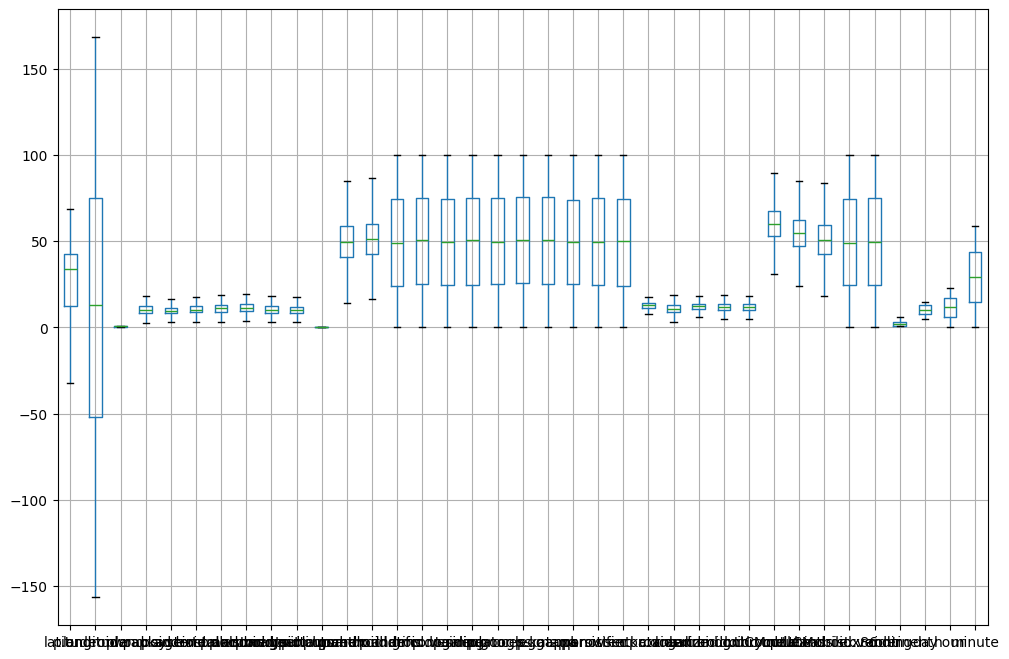

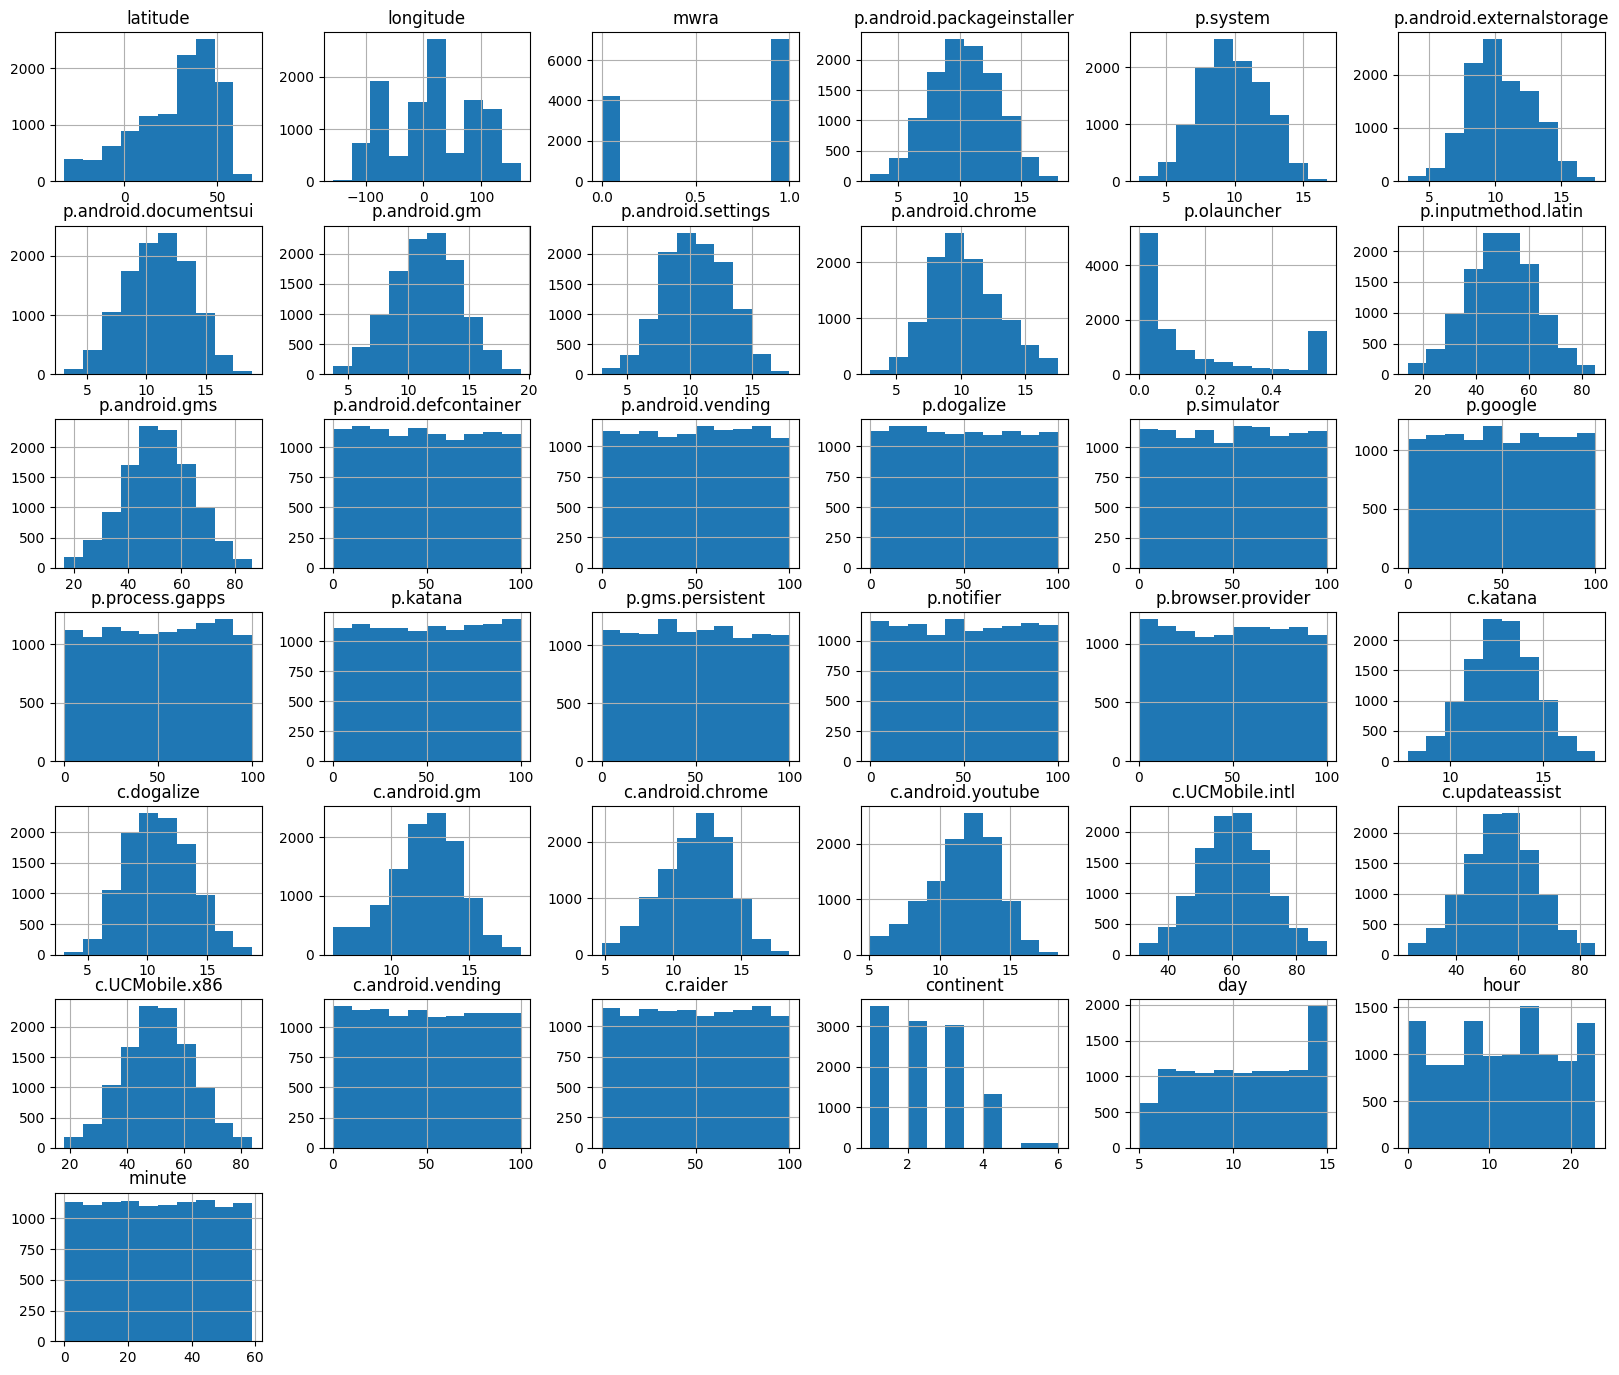

In [207]:
train_data.hist(figsize=(20, 17))
plt.show()

Let's now divide our attributes into groups based on the similarity of their distributions:

![grouping](https://raw.githubusercontent.com/myrres0/IAU-2024/main/img/grouping.png)

We did not assign the `mwra` attribute to any of the group distributions because it is an attribute we want to predict.

In [208]:
first_group = ['p.android.packageinstaller', 'p.system', 'p.android.externalstorage',
               'p.android.documentsui', 'p.android.gm', 'p.android.settings',
               'p.android.chrome', 'p.inputmethod.latin', 'p.android.gms',
               'c.katana', 'c.dogalize', 'c.android.gm','c.android.chrome',
               'c.android.youtube', 'c.UCMobile.intl', 'c.updateassist',
               'c.UCMobile.x86']

second_group = ['p.android.defcontainer', 'p.android.vending', 'p.dogalize',
                'p.simulator', 'p.google', 'p.process.gapps', 'p.katana',
                'p.gms.persistent', 'p.notifier', 'p.browser.provider',
                'c.android.vending', 'c.raider', 'minute']

third_group = ['latitude', 'longitude', 'p.olauncher', 'continent', 'day', 'hour']

## Data transformers
In next steps we are going to try different data transformers to see which one will give us the best results.

### Power transformer (yeo-johnson)
The PowerTransformer is a technique used to make numerical data resemble a Gaussian distribution more closely, which is often required for many machine learning models that operate under the assumption of normal distribution.

In [209]:
group1_df = train_data[first_group].copy()

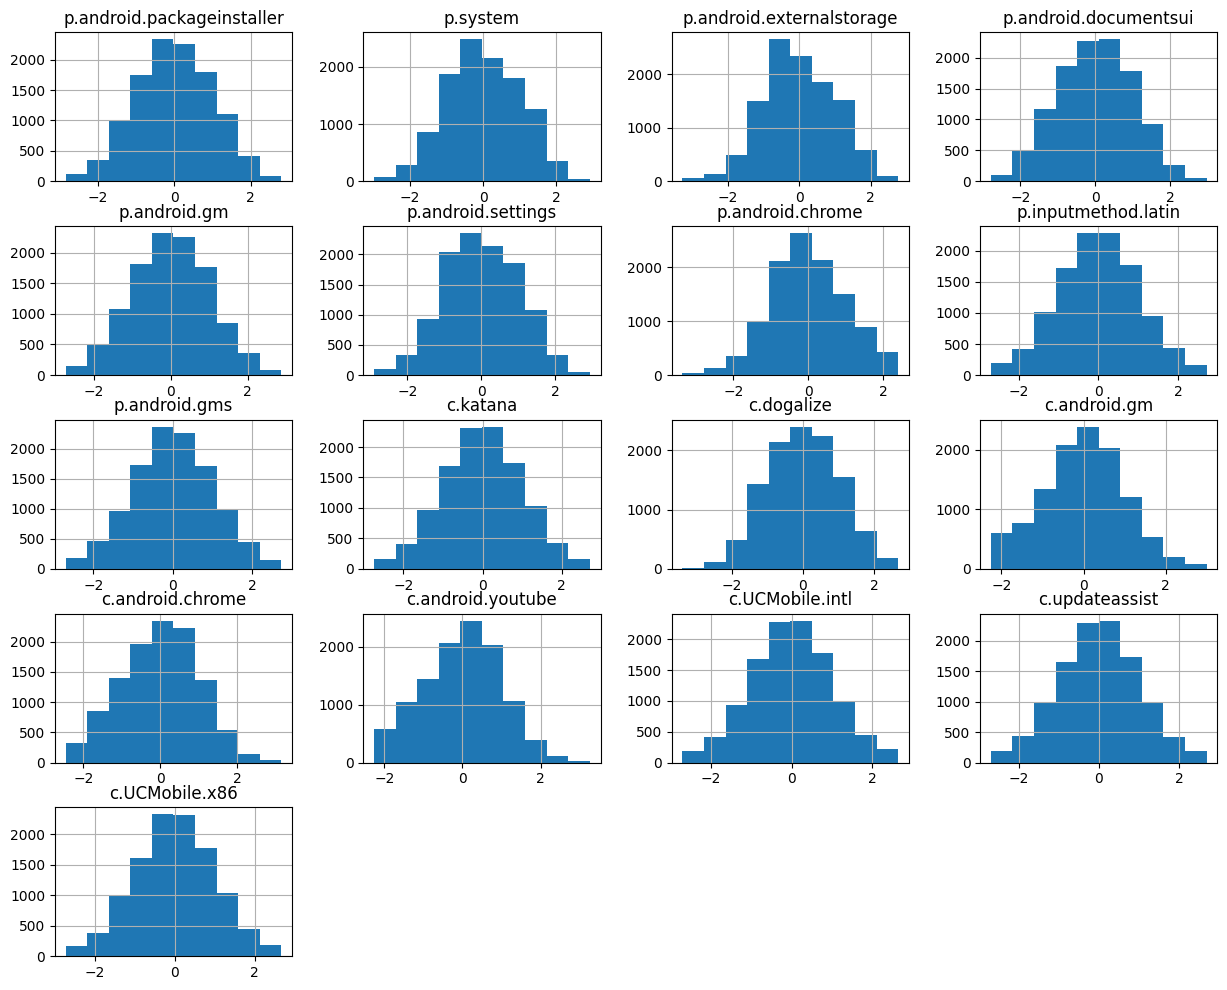

In [210]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

data_transformed = power_transformer.fit_transform(group1_df)
data_transformed = pd.DataFrame(data_transformed, columns=group1_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

Power transformer transforms data to similarly normally distributed data. It this example we used attributes with similar distribution to normal distribution to apply power transformer. That why the difference between the original and transformed data is not such visible.

Let's also apply power transformer to second and third group of attributes.

In [211]:
group2_df = train_data[second_group].copy()

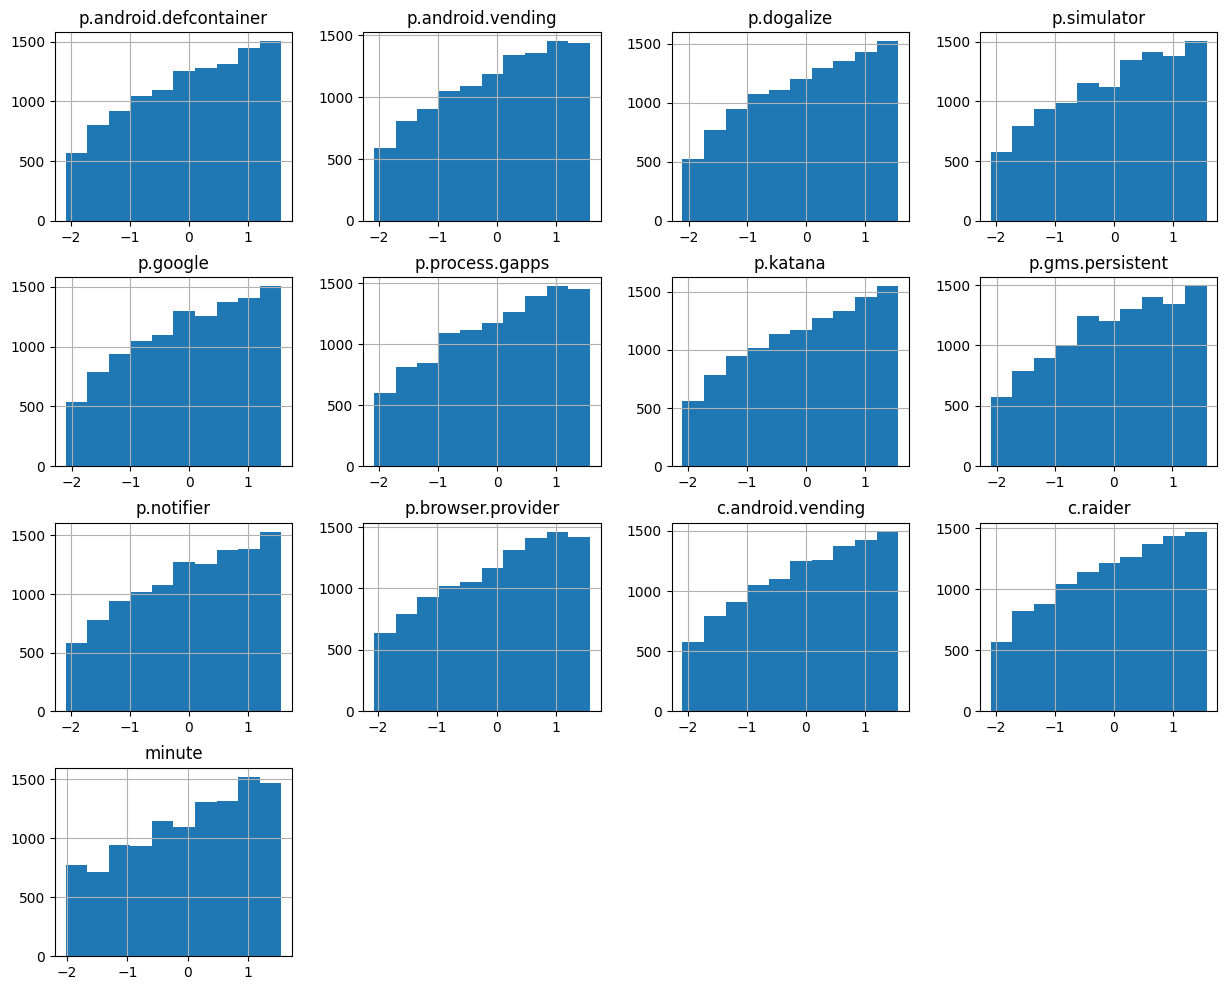

In [212]:
data_transformed = power_transformer.fit_transform(group2_df)
data_transformed = pd.DataFrame(data_transformed, columns=group2_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

In [213]:
group3_df = train_data[third_group].copy()

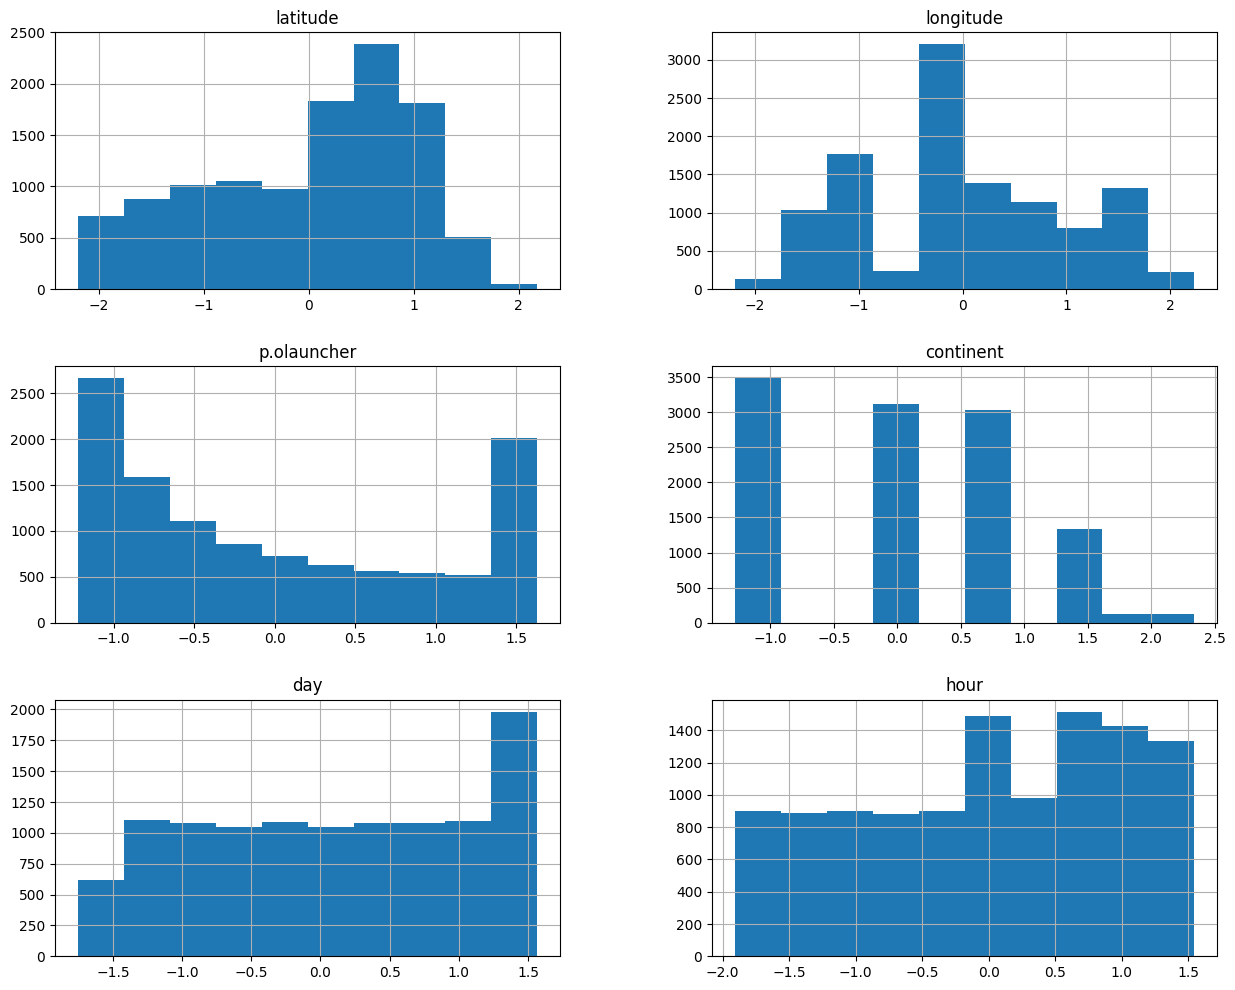

In [214]:
data_transformed = power_transformer.fit_transform(group3_df)
data_transformed = pd.DataFrame(data_transformed, columns=group3_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

As we can see on the pictures above in the second and third group the final distribution isn't close to normal distribution. That's why we will try another transformer.

### Quantile Transformer
Quantile transformation is an statistics approach to change the distribution a dataset is to normal distribution. Quantile transform works by changing the probability distribution of a measure to a different probability distribution.

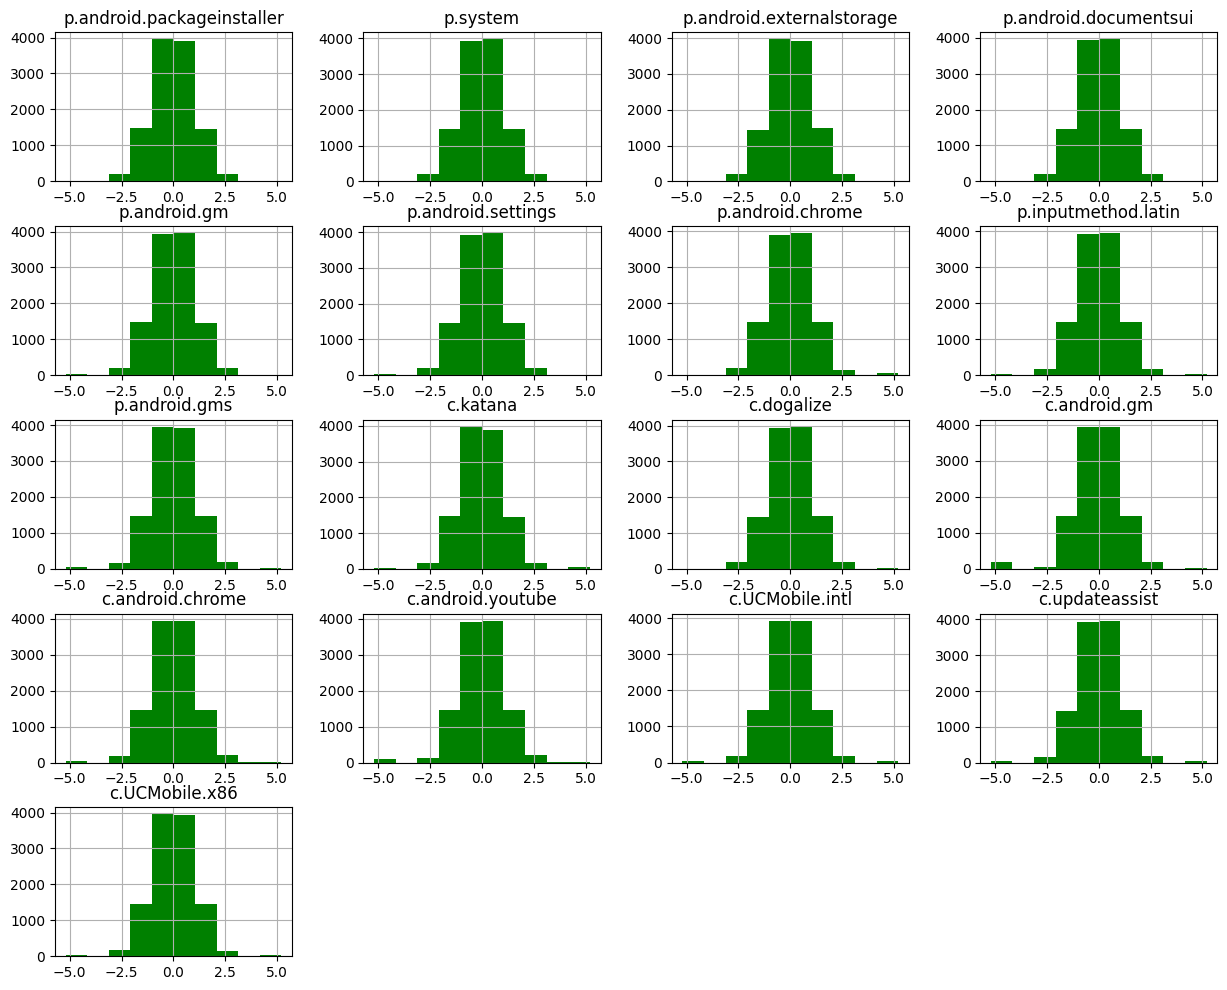

In [215]:
quantile_transformet = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)

data_transformed = quantile_transformet.fit_transform(group1_df)
data_transformed = pd.DataFrame(data_transformed, columns=group1_df.columns)

data_transformed.hist(figsize=(15, 12), color='green')
plt.show()


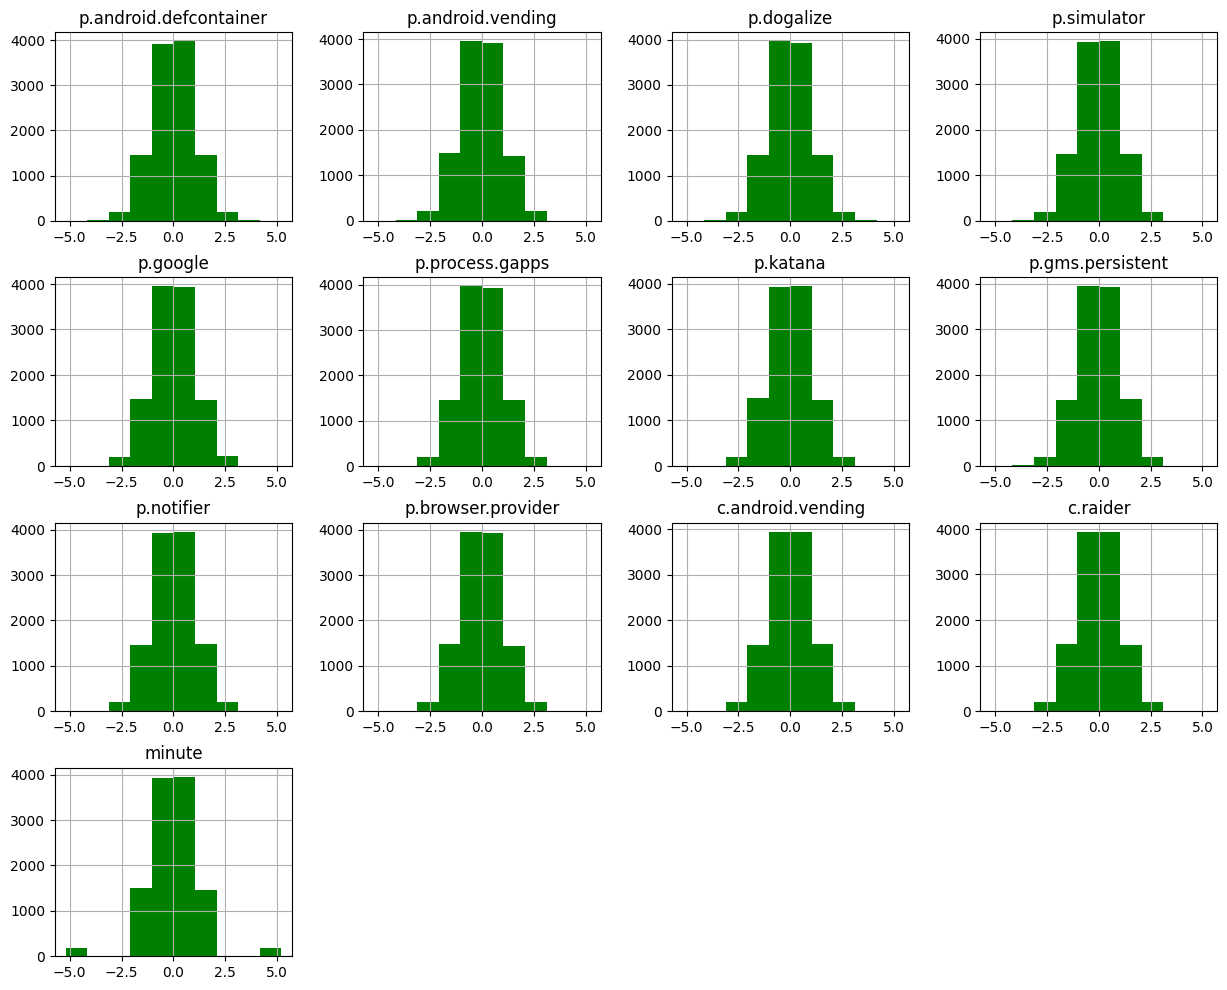

In [216]:
data_transformed = quantile_transformet.fit_transform(group2_df)
data_transformed = pd.DataFrame(data_transformed, columns=group2_df.columns)

data_transformed.hist(figsize=(15, 12),color="green")
plt.show()

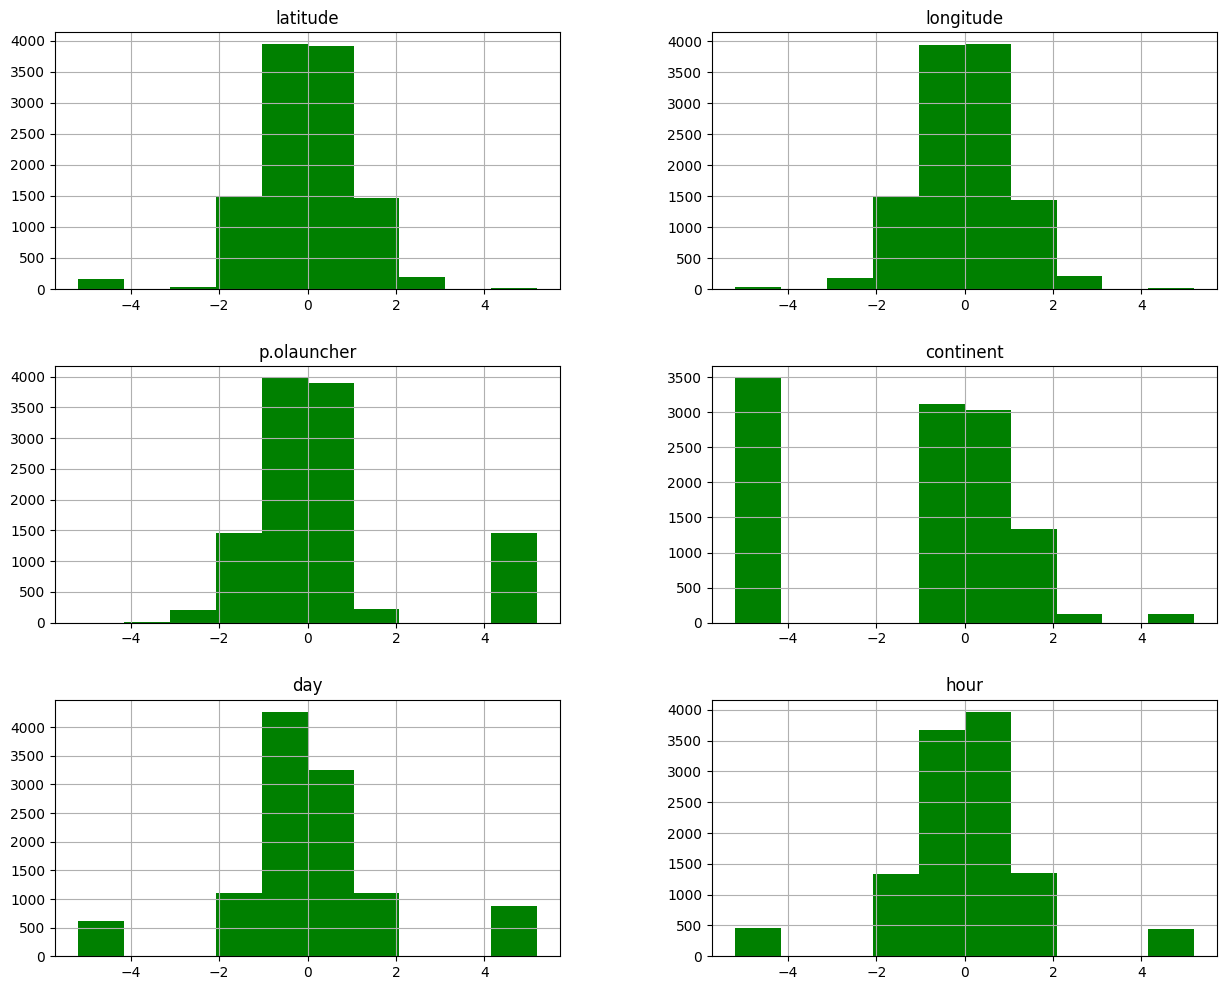

In [217]:
data_transformed = quantile_transformet.fit_transform(group3_df)
data_transformed = pd.DataFrame(data_transformed, columns=group3_df.columns)

data_transformed.hist(figsize=(15, 12), color='green')
plt.show()

The quantile transformer is a non-linear transformation. It smooths out unusual distributions and is less influenced by outliers than scaling methods. It also reduces the impact of outliers. That's why it worked well for the second and third group of attributes.

### Result transforming

After comparison these two transformers for different groups of attributes we can see that quantile transformer worked better for the second and third group of attributes, and power transformer worked better for the first group of attributes.
Let's transform our train data using this information

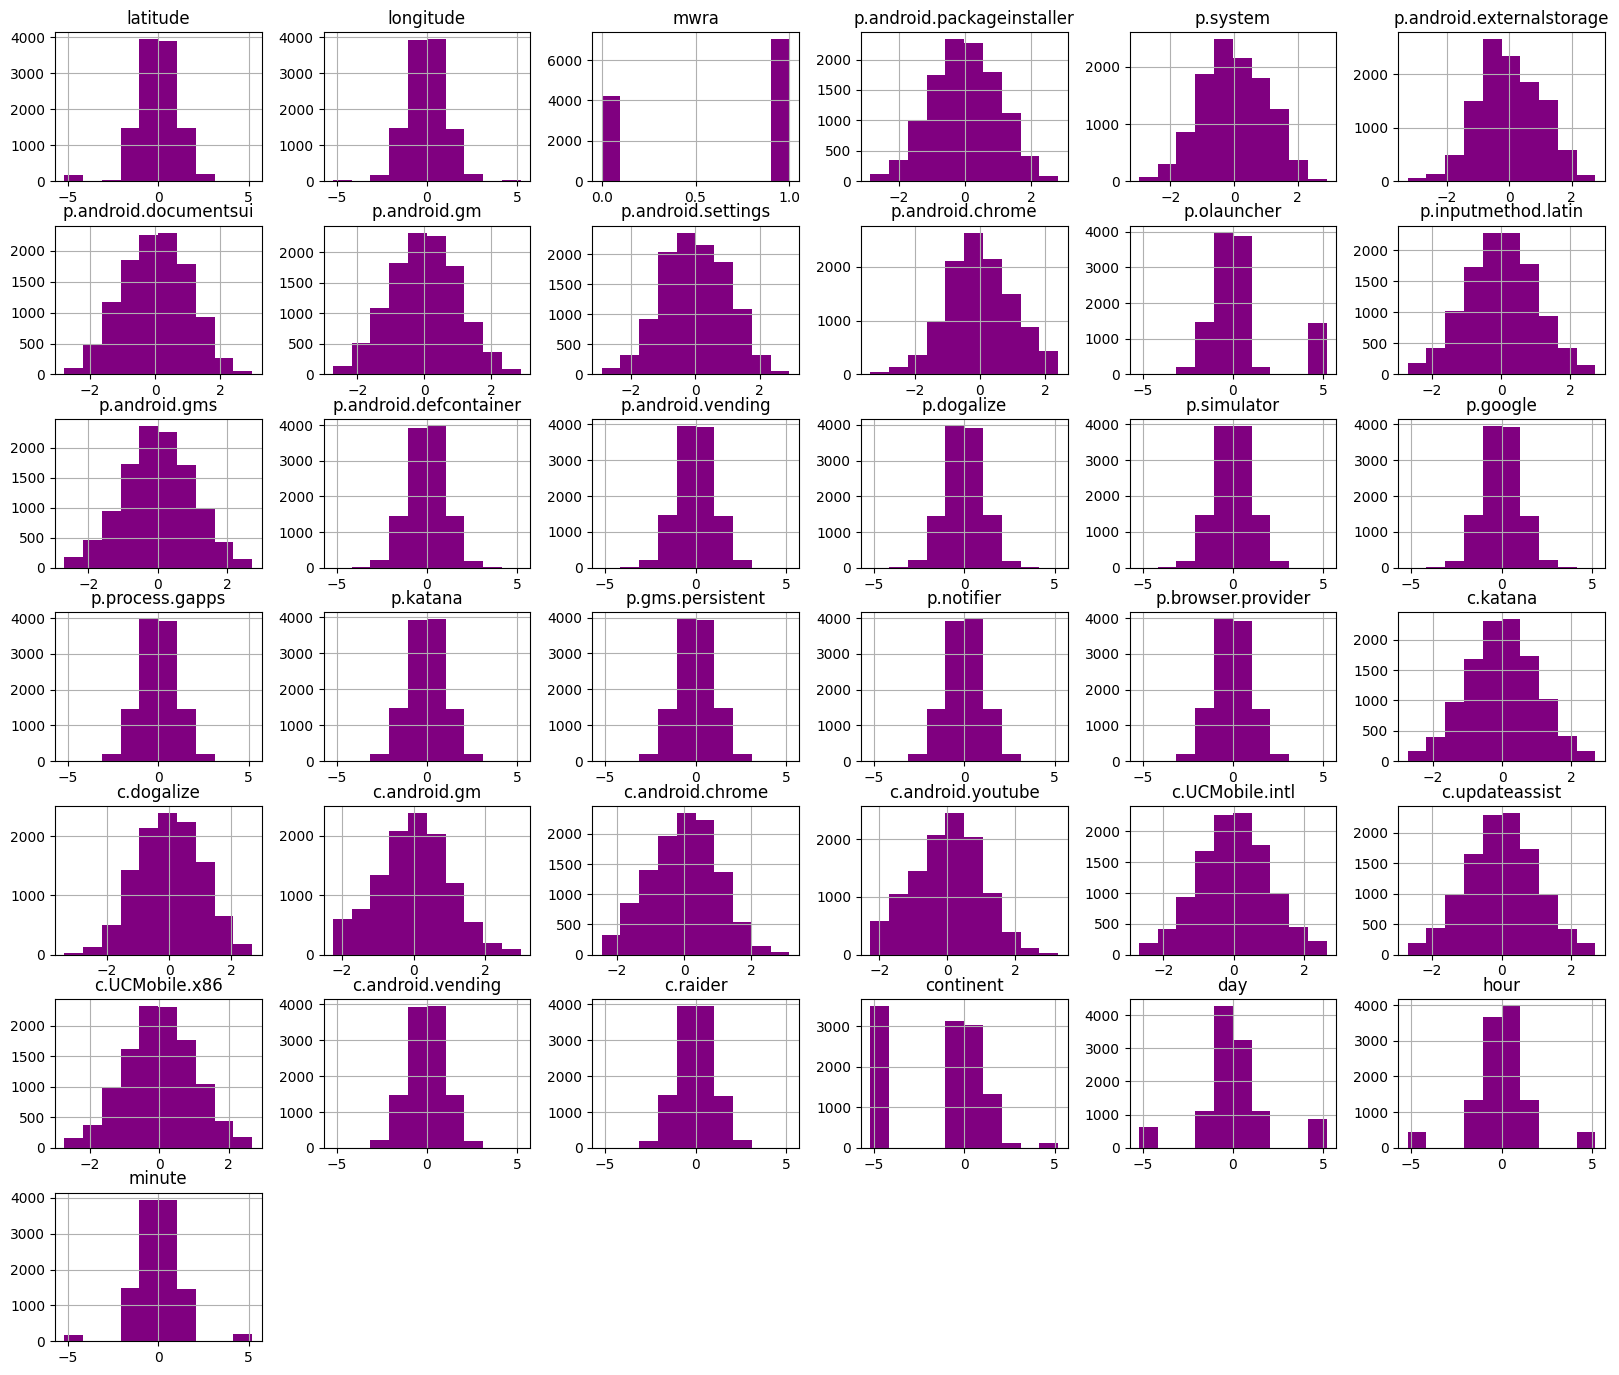

In [218]:
train_data[first_group] = power_transformer.fit_transform(train_data[first_group])
train_data[second_group] = quantile_transformet.fit_transform(train_data[second_group])
train_data[third_group] = quantile_transformet.fit_transform(train_data[third_group])

train_data.hist(figsize=(20, 17), color='purple')
plt.show()

## Data Scaling

"Many machine learning algorithms perform better or when features are relatively similar to normally distributed. Examples of such machine learning algorithms are linear regression,logistic regression, k-Nearest Neighbors algorithm, neural networks, Support Vector Machine, rincipal Components Analysis (PCA), inear Discriminant Analysis (LDA).

There are several scaling approaches such as:

* Normalization.

* Standardization.

* Robust scaler.

They are necessary in the case of very different values within the same feature (for example, city population). Without normalization (and/or standardization), the training could blow up to NaN (not a number) if the gradient update is too large."   
<p align="right">Giang Nguyen, "Introduction to Data Science"</p>

### Main difference

<table>
  <tr>
    <th>Scaling Approach</th>
    <th>Description</th>
    <th>When to Use</th>
  </tr>
  <tr>
    <td><strong>Normalization</strong></td>
    <td>Rescales values to a range, typically [0, 1] or [-1, 1].</td>
    <td>Useful when features have different scales and need to be in the same range for ML algorithms.</td>
  </tr>
  <tr>
    <td><strong>Standardization</strong></td>
    <td>Scales values to have a mean of 0 and a standard deviation of 1 (z-score).</td>
    <td>Commonly used for algorithms assuming a normal distribution, e.g., linear regression, SVM.</td>
  </tr>
  <tr>
    <td><strong>Robust Scaler</strong></td>
    <td>Scales based on the median and IQR (Interquartile Range), making it robust to outliers.</td>
    <td>Ideal for data with outliers, as it uses the median and IQR instead of mean and variance.</td>
  </tr>
</table>


- Uniformly Distributed Features: for features with uniform distributed, Min-Max Scaling (Normalization) might work best to bring values within a fixed range like [0, 1].
- Normally Distributed Features: for features with a normal distribution, Standardization (Z-score scaling) is generally effective as it centers the data around 0 with unit variance, aligning with the natural spread of the data.
- Highly Skewed or Outlier-Prone Features: for features with many outliers or a heavy skew, Robust Scaling (based on median and IQR) can be useful, as it minimizes the influence of extreme values.

### Result scaling

For group 1 we will use `StandardScaler` because these distributions had almost normal distribution from the beginning, for group 2 we will use `MinMaxScaler` because they have mostly Uniform distribution, and for group 3 `RobustScaler` because these values had other distributions and also the **p.olauncher** attribute, which had extreme values in part of this group.

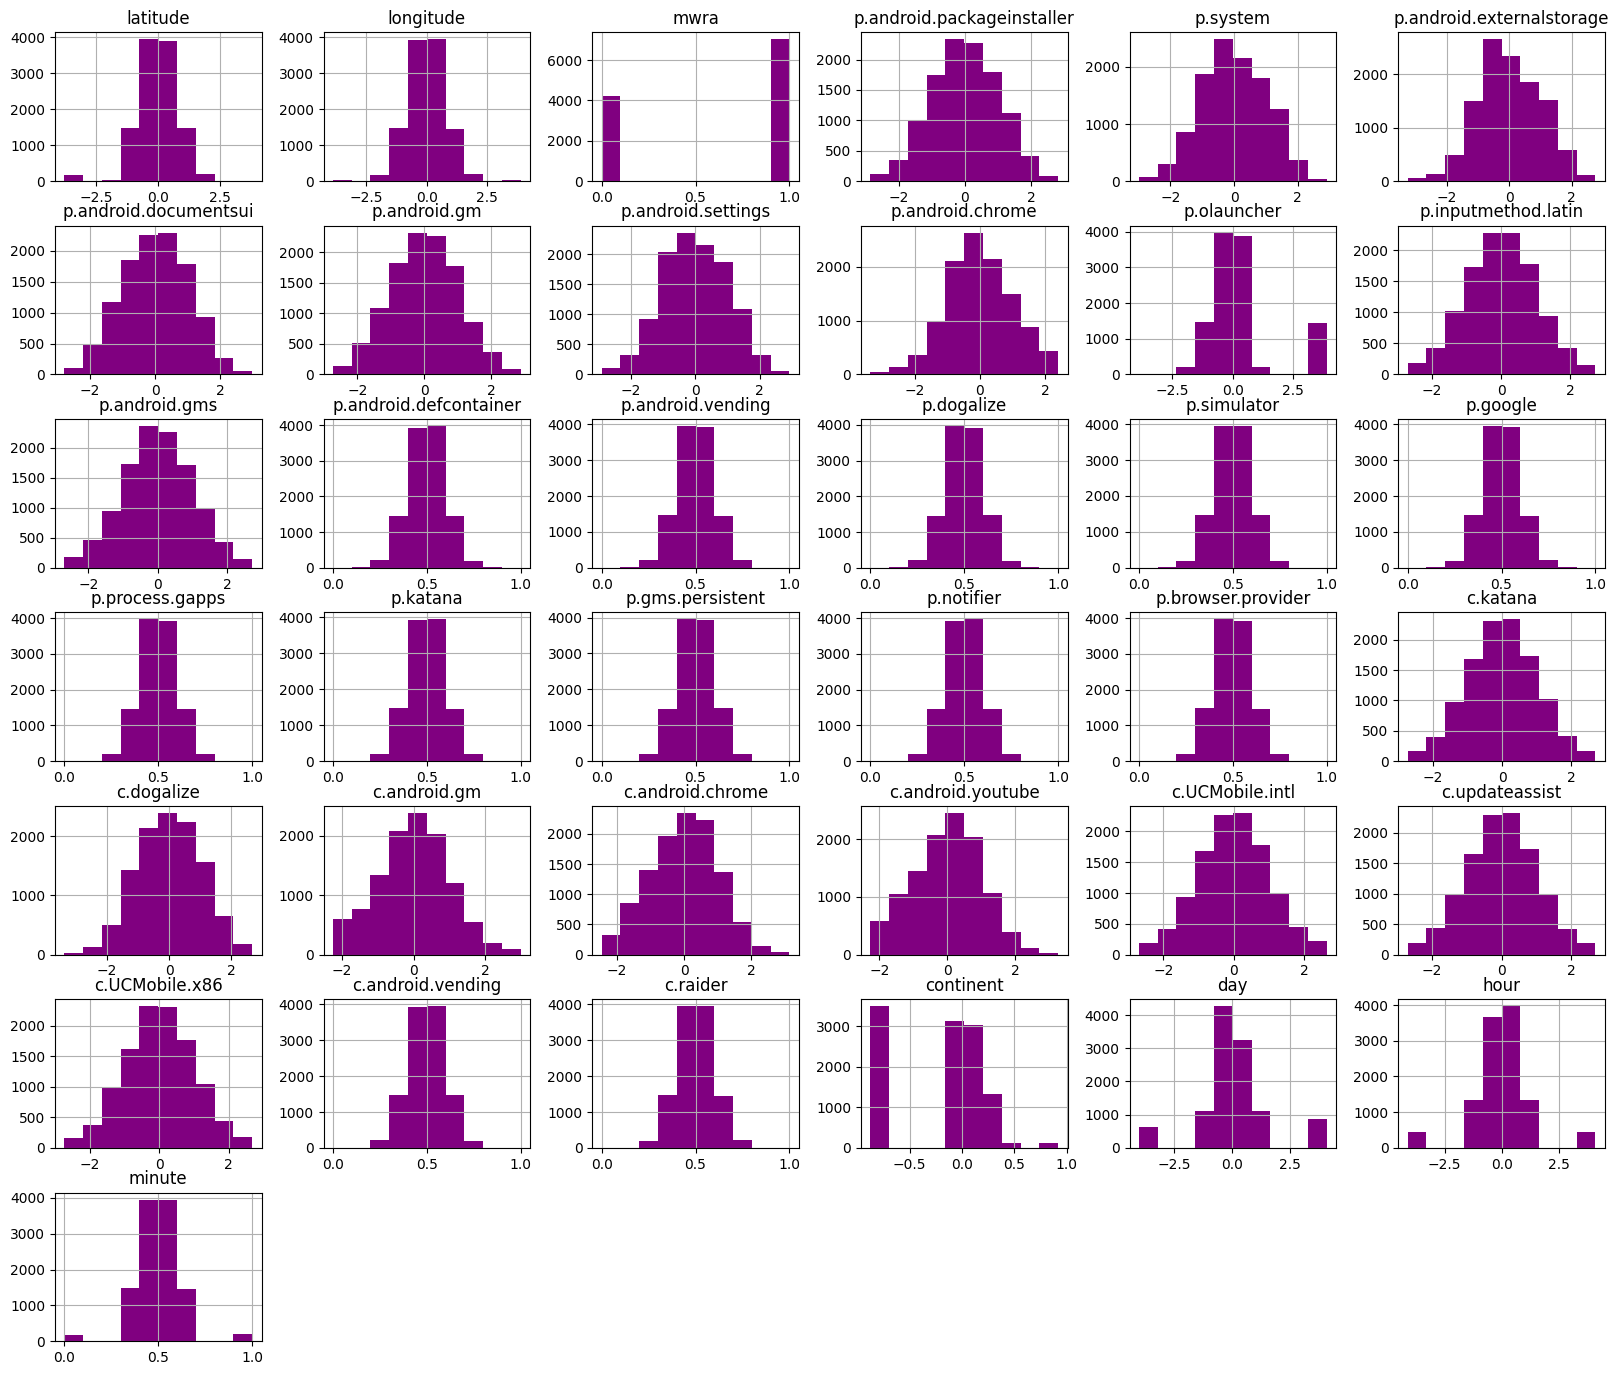

In [219]:
train_data[first_group] = StandardScaler().fit_transform(train_data[first_group])
train_data[second_group] = MinMaxScaler().fit_transform(train_data[second_group])
train_data[third_group] = RobustScaler().fit_transform(train_data[third_group])

train_data.hist(figsize=(20, 17), color='purple')
plt.show()

## Feature selection
Feature selection is a technique used to select a subset of input features that are most relevant to the target(mwra) variable that is being predicted. That way we can focus only on a subset of features that are most important for the prediction.

### Mutual Information (MI)
Mutual Information is a measure of the amount of randomness shared between two random variables X and Y.

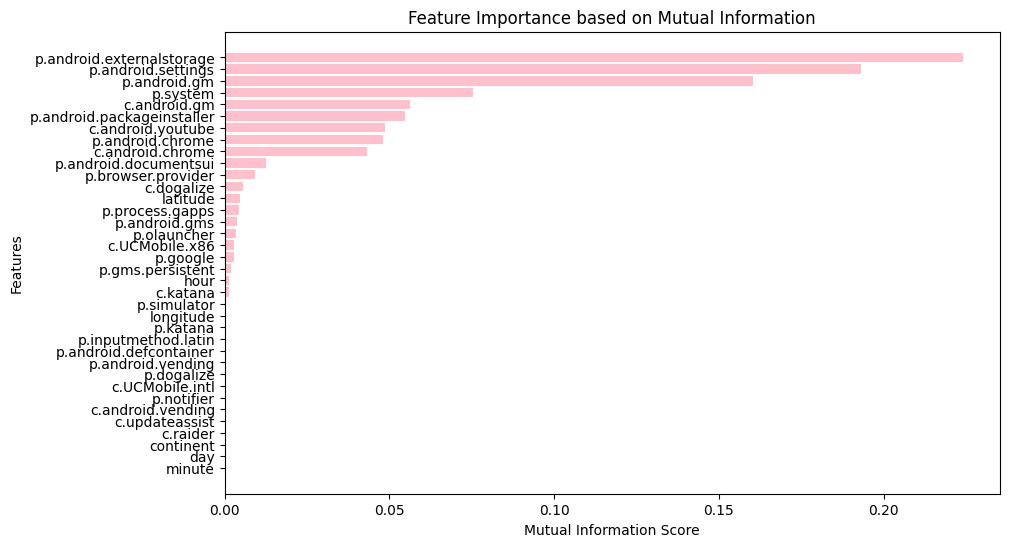

In [220]:
features = train_data.drop(columns=['mwra'])
target = train_data['mwra']

mi_scores = mutual_info_classif(features, target)

mi_scores = pd.DataFrame({
    "Feature": features.columns,
    "Mutual Information Score": mi_scores
})

mi_scores = mi_scores.sort_values(by="Mutual Information Score", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mi_scores["Feature"], mi_scores["Mutual Information Score"], color='pink')
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance based on Mutual Information")
plt.gca().invert_yaxis()
plt.show()


As we can see from the results above, the most important features based on MI are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- p.android.packageinstaller
- c.android.gm
- c.android.youtube
- p.android.chrome
- c.android.chrome

They are listed in descreasing order of importance.

### ANOVA F-Test

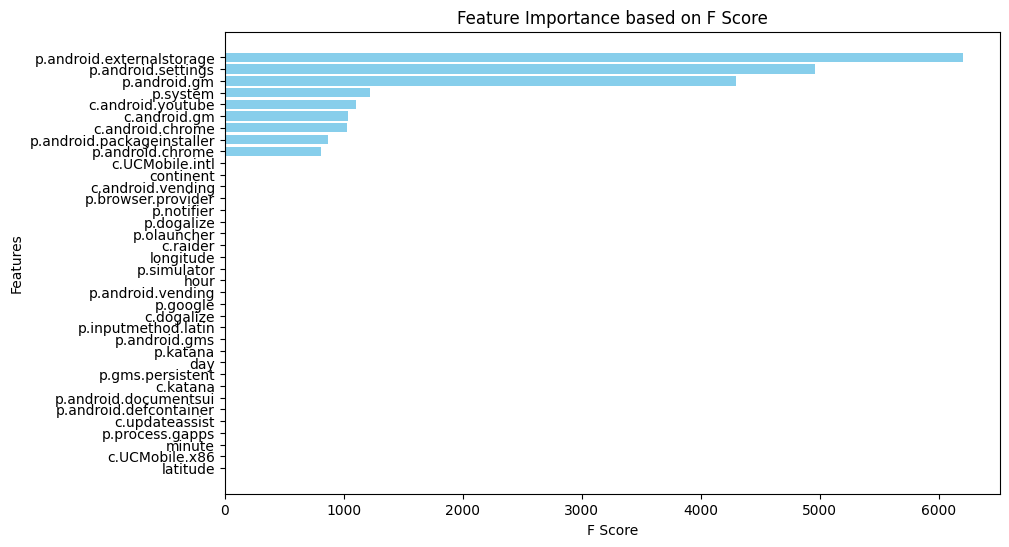

ANOVA F-Test Results:
                       Feature      F Score        P-Value
4    p.android.externalstorage  6204.892855   0.000000e+00
7           p.android.settings  4958.989033   0.000000e+00
6                 p.android.gm  4296.267916   0.000000e+00
3                     p.system  1224.759697  9.215064e-255
26           c.android.youtube  1100.637791  2.557655e-230
24                c.android.gm  1036.031483  1.695698e-217
25            c.android.chrome  1025.829620  1.820596e-215
2   p.android.packageinstaller   866.025466  1.984667e-183
8             p.android.chrome   812.981906  1.064010e-172
27             c.UCMobile.intl     6.415431   1.132680e-02
32                   continent     4.184604   4.081601e-02
30           c.android.vending     3.538711   5.997791e-02
21          p.browser.provider     2.512074   1.130053e-01
20                  p.notifier     2.446664   1.178032e-01
14                  p.dogalize     2.323575   1.274550e-01
9                  p.olauncher    

In [221]:
f_scores, p_values = f_classif(features, target)

f_scores = pd.DataFrame({
    "Feature": features.columns,
    "F Score": f_scores,
    "P-Value": p_values

})

f_scores = f_scores.sort_values(by="F Score", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(f_scores["Feature"], f_scores["F Score"], color='skyblue')
plt.xlabel("F Score")
plt.ylabel("Features")
plt.title("Feature Importance based on F Score")
plt.gca().invert_yaxis()
plt.show()

print("ANOVA F-Test Results:")
print(f_scores)

- F-Score: A higher F-Score suggests a feature is more likely to be informative for distinguishing categories in the target.
- P-Value: Lower p-values indicate stronger evidence against the null hypothesis (that the feature means are the same across categories), suggesting that the feature is relevant.

As we can see from the results above, the most important features based on ANOVA F-Test are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- c.android.youtube
- c.android.chrome
- c.android.gm
- p.android.packageinstaller
- p.android.chrome

Also based on the p value:
- p.android.externalstorage
- p.android.settings
- p.android.gm

had p value 0, which means that they are the most important features, and they are statistically significant. Other features listed above also had really low p values, which means that they are also statistically significant.

The first 4 features are the same as in the Mutual Information test, which means that they are the most important features for the prediction.

### Correlation

In [222]:
corr = abs(train_data.corr()["mwra"])
corr.sort_values(ascending=False).head(15)

mwra                          1.000000
p.android.externalstorage     0.596719
p.android.settings            0.553615
p.android.gm                  0.526184
p.system                      0.313700
c.android.youtube             0.298874
c.android.gm                  0.290733
c.android.chrome              0.289418
p.android.packageinstaller    0.267674
p.android.chrome              0.259918
c.UCMobile.intl               0.023904
continent                     0.019308
c.android.vending             0.017756
p.browser.provider            0.014961
p.notifier                    0.014765
Name: mwra, dtype: float64

Based on the correlation table, we can see that the most important features are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- c.android.youtube
- c.android.chrome
- c.android.gm
- p.android.packageinstaller
- p.android.chrome

All other features have a correlation coefficient close to 0, which means that they are not important for the prediction.

### Select from Model (Random Forest)

                       Feature  Importance
4    p.android.externalstorage    0.167536
7           p.android.settings    0.165971
6                 p.android.gm    0.104818
3                     p.system    0.061239
26           c.android.youtube    0.051221
25            c.android.chrome    0.045158
8             p.android.chrome    0.042407
24                c.android.gm    0.039564
2   p.android.packageinstaller    0.037563
23                  c.dogalize    0.029118


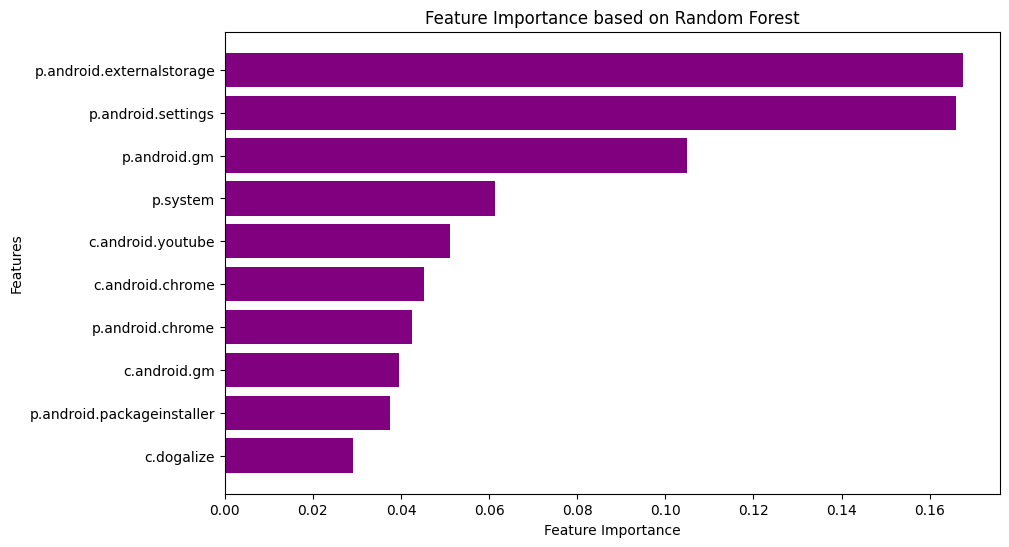

In [223]:
model = RandomForestClassifier(random_state=42)
model.fit(features, target)

selector = SelectFromModel(estimator=model, threshold="mean", prefit=True)
selector.fit(features, target)

feature_importances = model.feature_importances_
selected_features = features.columns[selector.get_support()]

importance_df = pd.DataFrame({
    "Feature": features.columns,
    "Importance": feature_importances
})
importance_df = importance_df[importance_df["Feature"].isin(selected_features)]
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance based on Random Forest")
plt.gca().invert_yaxis()
plt.show()

In the plot above we can see that the most important features are:
- p.android.settings
- p.android.externalstorage
- p.android.gm
- p.system
- c.android.youtube
- p.android.chrome
- p.adnroid.packageinstaller
- c.android.chrome
- c.android.gm
- c.dogalize


### Results
After following 4 tests, let's write down the most important features for the prediction in descending order:
1. p.android.externalstorage
2. p.android.settings
3. p.android.gm
4. p.system
5. c.android.youtube
6. c.android.chrome
7. c.android.gm
8. c.android.packageinstaller
9. p.android.chrome

In [224]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11223 entries, 6013 to 1479
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    11223 non-null  float64
 1   longitude                   11223 non-null  float64
 2   mwra                        11223 non-null  float64
 3   p.android.packageinstaller  11223 non-null  float64
 4   p.system                    11223 non-null  float64
 5   p.android.externalstorage   11223 non-null  float64
 6   p.android.documentsui       11223 non-null  float64
 7   p.android.gm                11223 non-null  float64
 8   p.android.settings          11223 non-null  float64
 9   p.android.chrome            11223 non-null  float64
 10  p.olauncher                 11223 non-null  float64
 11  p.inputmethod.latin         11223 non-null  float64
 12  p.android.gms               11223 non-null  float64
 13  p.android.defcontainer      11223 

## Replication of preprocessing

In [225]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

Let's create class-steps for pipeline:

### Data encoding

In [226]:
class ContinentEncoder(TransformerMixin):
    def __init__(self):
        self.continent_mapping = {
            'Asia': 1,
            'America': 2,
            'Europe': 3,
            'Africa': 4,
            'Australia': 5,
            'Indian': 6,
            'Pacific': 7
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['continent'] = X['continent'].map(self.continent_mapping)
        return X

In [227]:
class TsEncoder(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['ts'] = pd.to_datetime(X['ts'], format='%Y-%m-%d %H:%M:%S')
        X['day'] = X['ts'].dt.day
        X['hour'] = X['ts'].dt.hour
        X['minute'] = X['ts'].dt.minute
        X = X.drop(['ts'], axis=1)
        return X

### Data cleaning

In [228]:
class FeatureDropper(TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

In [229]:
class OutlierRemover(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.transform_outliers)

    # we have checked mrwa have no outliers so can also be proceeded by this function
    def transform_outliers(self, column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

      return cleaned_column

### Data transforming

In [230]:
class PowerTransformerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        self.power_transformer.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.power_transformer.transform(X[self.columns_to_transform])
        return X

In [231]:
class QuantileTransformerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.quantile_transformet = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)

    def fit(self, X, y=None):
        self.quantile_transformet.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.quantile_transformet.transform(X[self.columns_to_transform])
        return X

### Data scaling

In [232]:
class StandardScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.standard_scaler = StandardScaler()

    def fit(self, X, y=None):
        self.standard_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.standard_scaler.transform(X[self.columns_to_transform])
        return X

In [233]:
class MinMaxScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.min_max_scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.min_max_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.min_max_scaler.transform(X[self.columns_to_transform])
        return X

In [234]:
class RobustScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.robust_scaler = RobustScaler()

    def fit(self, X, y=None):
        self.robust_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.robust_scaler.transform(X[self.columns_to_transform])
        return X

In [235]:
class FeatureSelector(TransformerMixin):
    def __init__(self):
        self.target = 'mwra';
        self.selected_features = None

    def fit(self, X, y=None):
        target = X[self.target]
        features = X.drop(columns=[self.target])
        mi_scores = mutual_info_classif(features, target)
        
        mi_scores_df = pd.DataFrame({
            "Feature": features.columns,
            "Mutual Information Score": mi_scores
        }).sort_values(by="Mutual Information Score", ascending=False)
        self.selected_features = mi_scores_df["Feature"].tolist()
        return self

    def transform(self, X):
        return X[self.selected_features]


### Pipeline

Our constants:

In [236]:
columns_to_drop = ['store_name', 'code', 'city', 'imei']

first_group = ['p.android.packageinstaller', 'p.system', 'p.android.externalstorage',
               'p.android.documentsui', 'p.android.gm', 'p.android.settings',
               'p.android.chrome', 'p.inputmethod.latin', 'p.android.gms',
               'c.katana', 'c.dogalize', 'c.android.gm','c.android.chrome',
               'c.android.youtube', 'c.UCMobile.intl', 'c.updateassist',
               'c.UCMobile.x86']

second_group = ['p.android.defcontainer', 'p.android.vending', 'p.dogalize',
                'p.simulator', 'p.google', 'p.process.gapps', 'p.katana',
                'p.gms.persistent', 'p.notifier', 'p.browser.provider',
                'c.android.vending', 'c.raider', 'minute']

third_group = ['latitude', 'longitude', 'p.olauncher', 'continent', 'day', 'hour']

In [237]:
pipeline = Pipeline([
    ('continent_encoder', ContinentEncoder()),
    ('ts_encoder', TsEncoder()),
    ('feature_dropper', FeatureDropper(columns_to_drop)),
    ('outlier_remover', OutlierRemover()),
    ('power_transformer_group1', PowerTransformerGroup(first_group)),
    ('quantile_transformer_group_2', QuantileTransformerGroup(second_group)),
    ('quantile_transformer_group_3', QuantileTransformerGroup(third_group)),
    ('standard_scaler_group_1', StandardScalerGroup(first_group)),
    ('min_max_scaler_group_2', MinMaxScalerGroup(second_group)),
    ('robust_scaler_group_3', RobustScalerGroup(third_group)),
    ('feature_selector', FeatureSelector())
])

### Results on test dataset

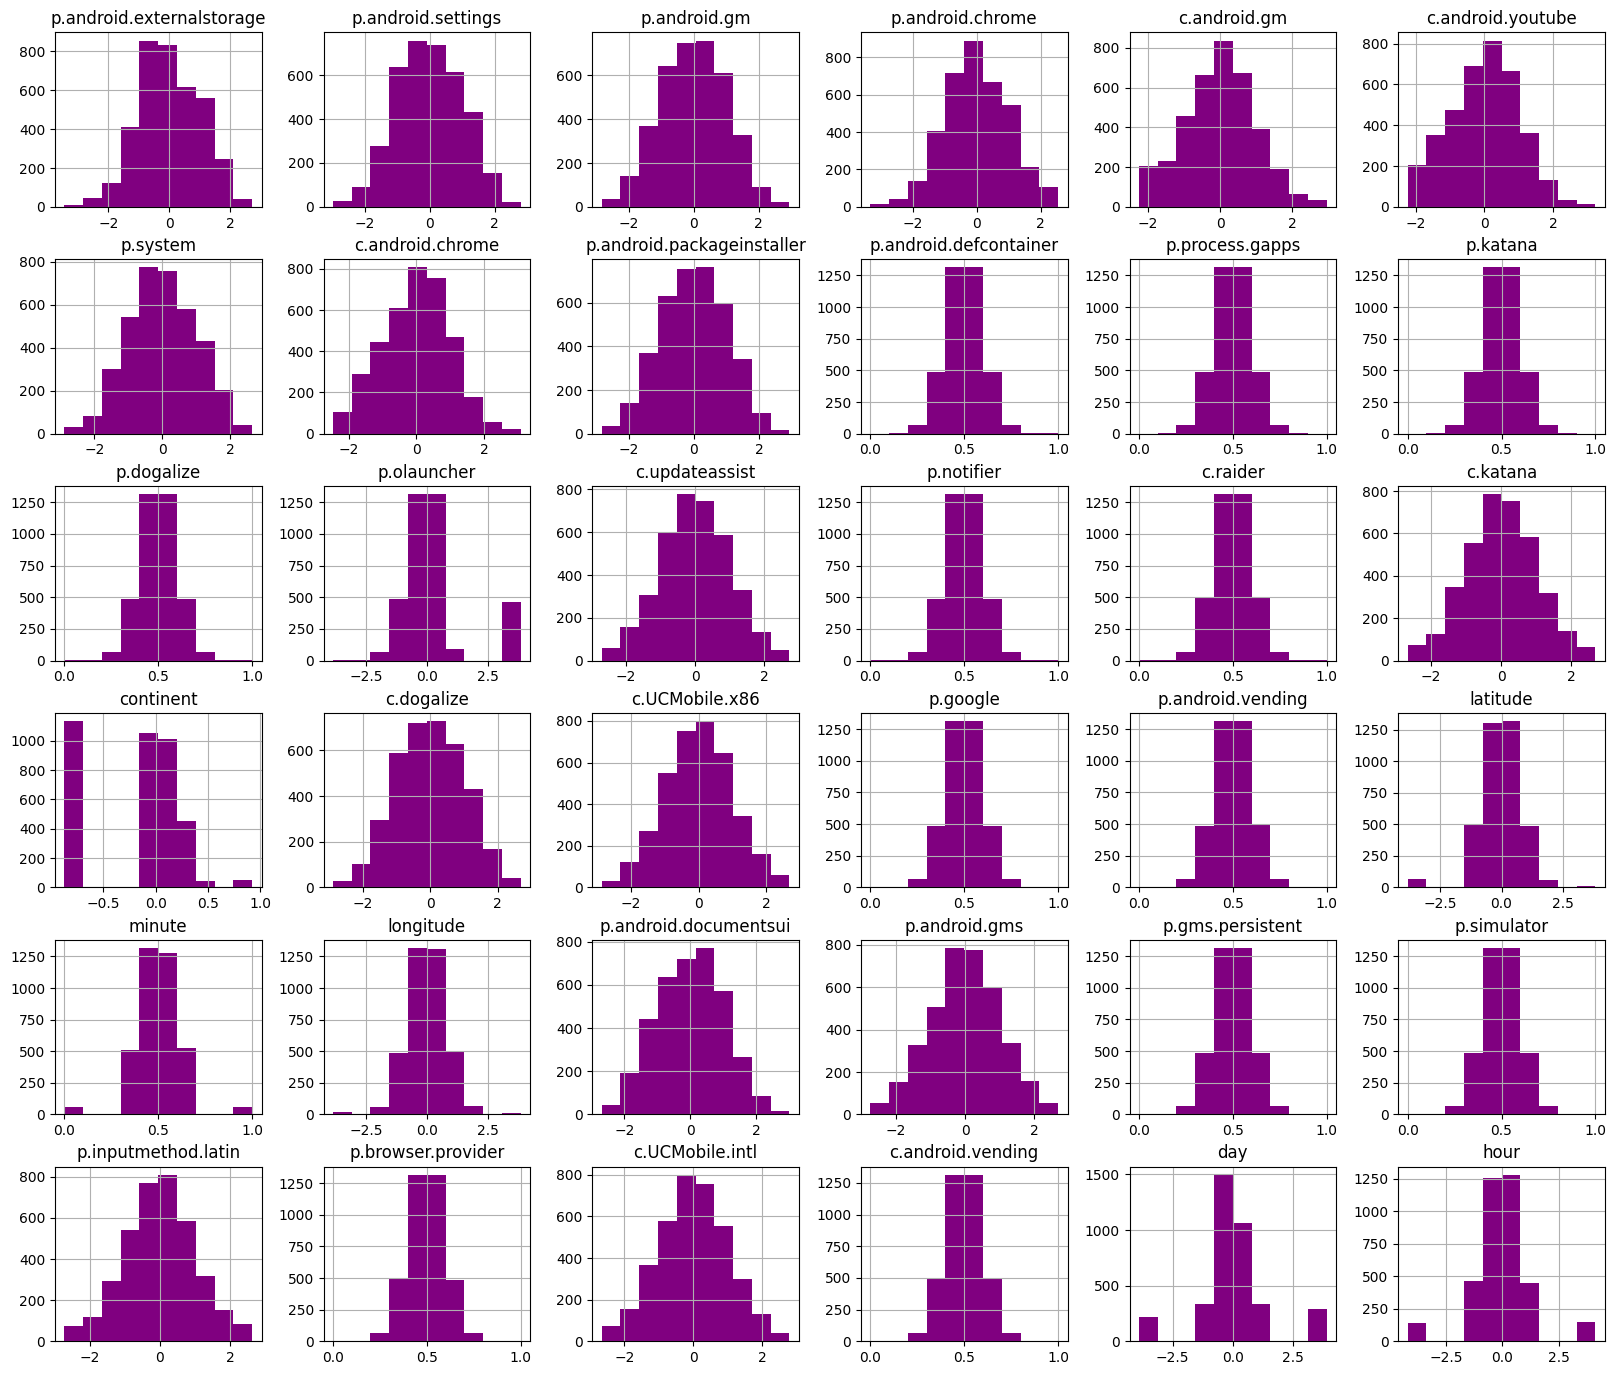

In [238]:
test_data_ppl = pipeline.fit_transform(test_data)
test_data_ppl.hist(figsize=(20, 17), color='purple')
plt.show()